## Noise in Mie scattering
Tricky little problem of how to add noise from a detector into the analytic Mie fucntion so that it accurately represents the noise we'd see in our data. The data are from radially averaging as real image collected in 2D, at angles up to 0.2rads. Have to set up teh geometry, make afake signal of the appropriate size, and then add noise to it, and then do the radial averaging.
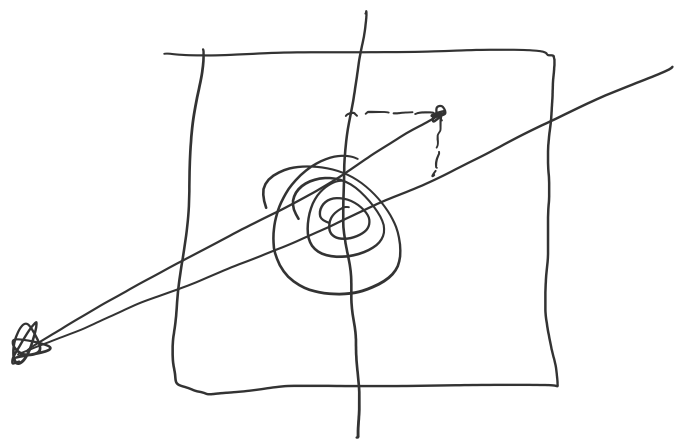


In [23]:
#Simplified import block...
import math
import numpy as np
import matplotlib.pyplot as plt
import mie_data_generator_function as mdg

In [24]:
#debug test thing
import ipykernel
ipykernel.__version__

'6.21.0'

In [25]:
#Set up the geometry
det_pix = [1024, 1024]
#det_pix = [256, 256]

pix_size = 13e-6   
theta_max = 0.2
det_distance = (pix_size * det_pix[0]/2) / np.tan(theta_max)
X = np.linspace(-pix_size*det_pix[0]/2, pix_size*(det_pix[0]/2-1), det_pix[0])
Y = np.linspace(-pix_size*det_pix[1]/2, pix_size*(det_pix[1]/2-1), det_pix[1])
x, y = np.meshgrid(X,Y)
r = np.sqrt(x**2 + y**2)
#now turn those into angles, and then reshape it into a single list  - I knwo it's computationally wasteful! COuld just do one quarter...
theta = np.arctan(r/det_distance)


In [26]:
#set up the bead parameters
lambda_ = 632.8e-9
radius = 8e-6
index1 = 1
index2 = 1.58

In [27]:
#visualise angle to check?
#fig, ax = plt.subplots()
#ax.pcolor(theta)
#plt.colorbar
#plt.show

In [28]:
#now create the Mie scattering...
th_length = det_pix[0]*det_pix[1]
theta_flat = np.reshape(theta, (1,th_length))
Iscat = mdg.mie_theta(lambda_, theta_flat, radius, index1, index2)
Iscat = Iscat.reshape(det_pix)

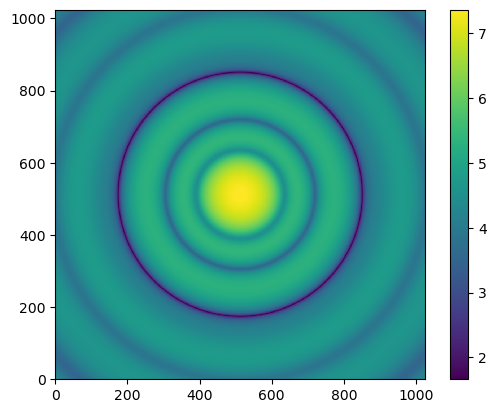

In [29]:
#and plot to check
fig, ax = plt.subplots()
p1 = ax.pcolormesh(np.log10(Iscat))
#ax.pcolor(Iscat)
ax.set_aspect('equal')
plt.colorbar(p1)
plt.show()

## Scaling the Mie signal.  
OK, now we have the basic Mie signal, we have to re-size it to have a reasonable photon count. Can set peak, or integral. Peak is given by the bit depth of the detector, usually less than 64k for our CCDs. If we're in the X-ray region, then we might be more limited by flux than by bit depth. Howver, it's not a bad approximation to think that we'd run the experiment until the CCD wells were nearly full. Let's see what the integral is if we set the peak flux to, let's say, 50k per pixel (although the HDR technique usually lets us get at least 2 orders of magnitude better)

In [30]:
# signal scaling - max of Iscat as calculated?
max_count = 1e2  # set the maximum level we'll use
Iscat = max_count * Iscat/Iscat.max()
print(Iscat.max())
#what's the integrated count now?
print("Integrated count over the CCD is {:.3}".format(Iscat.sum()))
print("when the max count is set to {}".format(max_count))

100.0
Integrated count over the CCD is 1.27e+06
when the max count is set to 100.0


The actual signal we use is a radial integral, and the noise will depend on the total signal. In each ring, we divide by the area to get the scaled signal, so that the actual signal at each point is the radial integral \emph{times} the area. Here we can make a radial integral and see what the actual noise is. Numpy has a poisson function, wihch I might just test here

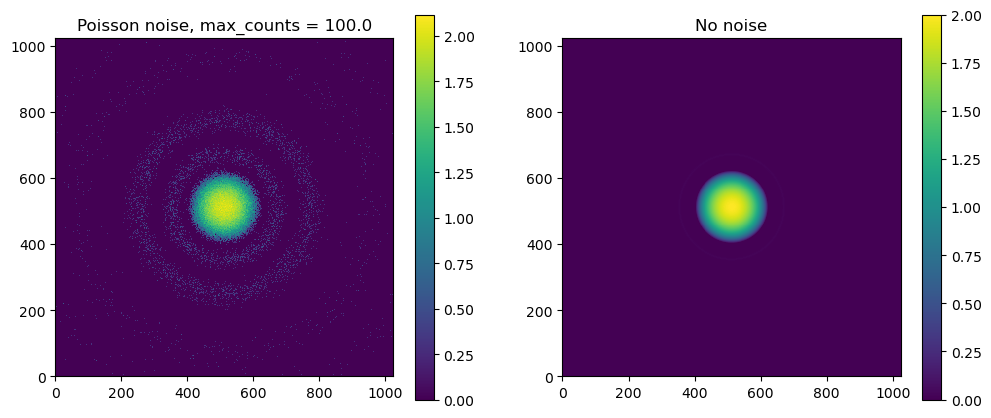

In [31]:
Iscat_n= np.random.poisson(Iscat)
Iscat_n[Iscat_n<1]=1 #get rid of zeros
#and plot to check
fig, ax = plt.subplots(1,2, figsize=(12,5))
p1 = ax[0].pcolormesh(np.log10(Iscat_n))
#ax.pcolor(Iscat)
ax[0].set_aspect('equal')
ax[0].set_title('Poisson noise, max_counts = {}'.format(max_count))
plt.colorbar(p1)
p2 = ax[1].pcolormesh(np.log10(Iscat), vmin=0, vmax= np.log10(max_count))
#ax.pcolor(Iscat)
ax[1].set_aspect('equal')
ax[1].set_title('No noise')
plt.colorbar(p2)
plt.show()

Next I need to make th radial integrals here - do it by hand first and then functionalise it. Easy as I know the centres...

In [32]:
n_rings = 300
ring_coords = np.linspace(0,512, n_rings)
ring_width = ring_coords[1]-ring_coords[0]
ring_theta = np.arctan((ring_coords+ring_width/2)*pix_size/det_distance)  #need to add half the ring width to make it accurate
Xm = np.arange(-512, 512)
xm, ym = np.meshgrid(Xm, Xm)
rm = np.sqrt(xm**2 + ym**2)   #pixel number arrays to use
Irad = np.zeros(ring_coords.shape)
for ii in range(0,n_rings-1):
    #define the ring
    mask = np.ones(Iscat.shape)
    mask[rm > ring_coords[ii+1]]=0
    mask[rm <= ring_coords[ii]]=0
    Iring = Iscat_n * mask
    Irad[ii] = Iring.sum()/mask.sum()
    
Irad[Irad<1]=1; #get rid of zeros again for plot


So next I better compare this to the calculated Mie signal, which I shou dbe able to get directly from the angle array of the rings.

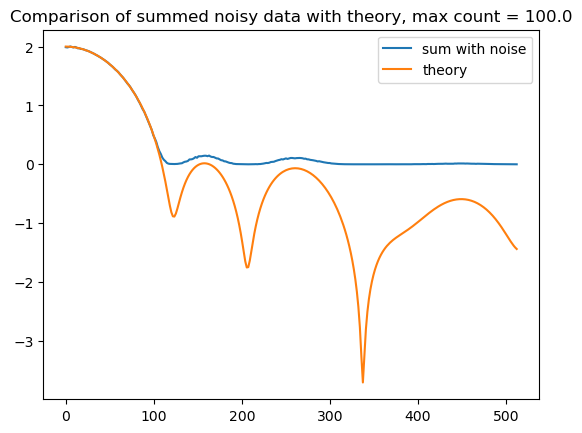

In [33]:
Iscat_theory= mdg.mie_theta(lambda_, ring_theta.reshape(1,n_rings), radius, index1, index2)
Iscat_theory = max_count * Iscat_theory/Iscat_theory.max()

fig, ax = plt.subplots()
ax.plot(ring_coords, np.log10(Irad), label='sum with noise')
#ax.pcolormesh(mask)
#plt.show()
ax.plot(ring_coords, np.log10(Iscat_theory), label = 'theory')
ax.legend()
ax.set_title('Comparison of summed noisy data with theory, max count = {}'.format(max_count))
plt.show()



### Summary
So, there it is. The noise level from Poisson stats is imperceptible, and the effect of the dynamic range is much more stringent. It puts a line across at the base level - above it's for a 1000 count max so the effect is quite big, smoothing out anything that goes below 1 count, just as you'd expect. So HDR is the key rather than noise. Need to look at Rhys's data and see what the dynamic range is/was. 

### Other errors
Could also use this to look at the effects of the centre being wrong, that might be interesting. 